# Fabry Perot Interferometer (OLD VERSION)

Reference: https://opticspy.github.io/lightpipes/FabryPerot.html 

### A) When $R_1=R_2$

#### 1. Simple Simulation

In [ ]:
# Preamble
import matplotlib.pyplot as plt
import numpy as np
from LightPipes import *

# Parameters
labda = 550*nm;     # Wavelength
size = 5*mm;        # Size of grid
N = 300             # Grid dimension
f = 100*mm;         # Lens focal length
r = 0.85;           # Reflectivity of mirror
d = 6*mm;           # Separation bewteen two mirrors
k = 2*np.pi/labda;  # Wavenumber
n = 1.0             # Medium refractive index

# Create matplotlib figure and axes 
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# Font Customization
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'Liberation Sans'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['figure.dpi'] = 100

# Laser start
F_prime = (4.0 * r)/ (1.0 - r)**2         # F'
finesse = (np.pi * np.sqrt(r)) / (1 - r)  # Finesse
F = Begin(size, labda, N);                # Create ray
I = Intensity(F, flag=1)                  # Normalised intensity (all generated points have equal intensity)
I0 = I[0][0]                              # Obtain initial intensity
step = size / N                           # Iteration step size = 0.0167mm

# This section calculates intensity, I at every point on the grid
# Does this by iterating all possible points (x0 = -size/2 to xn = size/2) where (x0 = -R to x = R)
# Loops over x-axes's grid dimension (N=300)
for i in range(1, N):
    x_ray = i * step
    # Loops over x-axes's grid dimension (N=300)
    for j in range(1, N):
        y_ray = j * step
        X = x_ray - (size/2)         # {x: -size/2 < x < size/2, or -R < x < R}
        Y = y_ray - (size/2)         # {y: -size/2 < y < size/2, or -R < y < R}
        radius = np.sqrt(X**2 + Y**2)   # Pythagoras
        theta = radius / f              # Small angle approximation for divergence, theta = tan(theta)
        Phi = 2 * k * n * d * np.cos(theta) # Phi angle (round trip)
        Inten = 1 / (1 + F_prime * np.sin(Phi/2)**2) # Assuming no loss and T + R = 1
        I[i][j] = I0 * Inten

# 1. Plot circular fringes
ax1.clear()
ax1.axis('on'); ax1.axis('equal');
ax1.set_title('Intensity distribution')
im = ax1.imshow(I, cmap='hot')
fig.colorbar(im, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04)

# 2. Plot finesse graph
r_lin = (np.arange(0, 100, 1)) / 100
Fin_lin = (np.pi * np.sqrt(r_lin)) / (1 - r_lin)
ax2.plot(r_lin, Fin_lin, color='royalblue')
# ax2.plot(r_lin, (4*r_lin) / (1 - r_lin)**2, color='crimson')
ax2.scatter(r, finesse, color='navy', marker='^')
ax2.grid()
ax2.set_title(r"Plot of Finesse, $\mathcal{F}$")

plt.show()

: 

#### 2. Dynamic Simulation

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np
from LightPipes import *

from tkinter import *
from tkinter import messagebox
from tkinter import ttk

###########################
# Tkinter Functions
###########################

def update_plot():    
    r = R_val.get();             # Reflectivity of mirror
    d = d_val.get()*mm;          # Separation between two mirrors
    n = n_val.get()              # Medium refractive index 
    labda = labda_val.get()*nm   # Wavelength

    k = 2*np.pi/labda

    # If reflectivity, r = 1
    try:
        F_prime = (4.0 * r)/ (1.0 - r)**2
        finesse = (np.pi * np.sqrt(r)) / (1 - r)
    except ZeroDivisionError:
        F_prime = 99999
        finesse = 0


    # This section draws the circular shape (rings)
    # Does this by iterating all possible points (x0 = -size/2 to xn = size/2) where (x0 = -R to x = R)
    # Loops over x-axes's grid dimension (N=300)
    # Iteration step size = 0.0167mm
    x = np.linspace(-size/2, size/2, NN)
    y = np.linspace(-size/2, size/2, NN)
    XX, YY = np.meshgrid(x, y)
    radius = np.sqrt(XX**2 + YY**2)
    theta = radius / f
    Phi = 2 * k * n * d * np.cos(theta)
    Inten = 1 / (1 + F_prime * np.sin(Phi/2)**2)
    I = I0 * Inten

    # 1. Plot circular fringes
    global cbar, im

    try:
        cbar.remove()
        im.remove()
    except:
        pass
    im = ax1.imshow(I, cmap='hot')
    cbar = fig.colorbar(im, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04)
    
    # 2. Plot finesse graph
    global scatter2

    try:
        scatter2.remove()
    except:
        pass
    scatter2 = ax2.scatter(r, finesse, label=rf"$\mathcal{{R}}={r:.2f},\ \mathcal{{F}}={finesse:.2f}$", color='navy', marker='^')
    ax2.grid(True, ls=":")
    ax2.legend(loc='upper left')

    # Updates canvas
    canvas.draw()


def update_R(val):
    label_R.config(text=f"Reflectivity, R = {float(val):.2f}")  # Format to 2 decimal places
    update_plot()

def update_n(val):
    label_n.config(text=f"Refractive index, n = {float(val):.2f}")  # Format to 2 decimal places
    update_plot()

def toggle_n_scale():
    if n_bool.get():
        n_scale.config(state="normal")
    else:
        n_scale.config(state="disabled")

def update_d(val):
    label_d.config(text=f"Distance between mirrors, d = {float(val):.2f}mm")  # Format to 2 decimal places
    update_plot()

def toggle_d_scale():
    if d_bool.get():
        d_scale.config(state="normal")
    else:
        d_scale.config(state="disabled")

def update_labda(val):
    label_labda.config(text=f"Wavelength, λ = {float(val):.0f}nm")  # Format to 2 decimal places
    update_plot()

def toggle_labda_scale():
    if labda_bool.get():
        labda_scale.config(state="normal")
    else:
        labda_scale.config(state="disabled")

def on_closing():
    # Ask user if they really want to quit
    if messagebox.askokcancel("Quit", "Do you want to quit?"):
        root.destroy()  # Close the window and exit app


###########################
# Matplotlib Customization
###########################

# Font Customization
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['figure.dpi'] = 100

# Create matplotlib figure and axes 
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.axis('on'); ax1.axis('equal');
ax1.set_title('Intensity distribution')

ax2.set_title('Plot of Finesse, $\mathcal{F}$')


###########################
# Simulation Start
###########################

# Parameters
labda = 550*nm;     # Wavelength
size = 5*mm;        # Size of grid
NN = 300            # Grid dimension
f = 100*mm;         # Lens focal length
r = 0.7;            # Reflectivity of mirror
d = 6*mm;           # Separation bewteen two mirrors
k = 2*np.pi/labda;  # Wavenumber
n = 1.0             # Medium refractive index

# Laser start
F = Begin(size, labda, NN)
I = Intensity(F, flag=1)      # Normalised intensity (all generated points have equal intensity)
I0 = I[0][0]                  # Obtain initial intensity

# Finesse curve
r_lin = (np.arange(0, 97, 1)) / 100 
Fin_lin = (np.pi * np.sqrt(r_lin)) / (1 - r_lin)

# Prevent unecessary computation
plot2 = ax2.plot(r_lin, Fin_lin, color='royalblue')


###########################
# TkAgg Start
###########################

root = Tk()
root.title("Fabry Perot Simulation")

# Frames
content = ttk.Frame(root, padding=(3,3,12,12))
frame1 = ttk.Frame(content, borderwidth=5, relief="ridge", width=200, height=100)
frame2 = ttk.Frame(content, borderwidth=5, relief="ridge")

# Matplotlib canvas
canvas = FigureCanvasTkAgg(fig, master=frame1)
canvas.draw()
canvas.get_tk_widget().pack(side=TOP, fill=X)

# Variables
R_val = DoubleVar(value=0.5)

n_bool = BooleanVar(value=False)
d_bool = BooleanVar(value=False)
labda_bool = BooleanVar()

n_val = DoubleVar(value=1.0)
d_val = DoubleVar(value=6.0)
labda_val = DoubleVar(value=550)

# Widgets
label_R = ttk.Label(frame2, text=f'Reflectivity, R = {R_val.get():.2f}')
R = ttk.Scale(frame2, orient=HORIZONTAL, length=200, from_=0.00, to=1.00, variable=R_val, command=update_R)
R.set(R_val.get())


label_n = ttk.Label(frame2, text=f'Refractive index, n = {n_val.get():.2f}')
n_scale = ttk.Scale(frame2, orient=HORIZONTAL, length=200, from_=1.00, to=3.00, variable=n_val, command=update_n)
n_scale.set(n_val.get())
n_check = ttk.Checkbutton(frame2, text="Allow", variable=n_bool, onvalue=True, command=toggle_n_scale)

label_d = ttk.Label(frame2, text=f'Distance between mirros, d = {d_val.get():.2f}mm')
d_scale = ttk.Scale(frame2, orient=HORIZONTAL, length=200, from_=0.00, to=10.00, variable=d_val, command=update_d)
d_scale.set(d_val.get())
d_check = ttk.Checkbutton(frame2, text="Allow", variable=d_bool, onvalue=True, command=toggle_d_scale)

label_labda = ttk.Label(frame2, text=f'Wavelength, λ = {labda_val.get():.0f}nm')
labda_scale = ttk.Scale(frame2, orient=HORIZONTAL, length=200, from_=10, to=990, variable=labda_val, command=update_labda)
labda_scale.set(labda_val.get())
labda_check = ttk.Checkbutton(frame2, text="Allow", variable=labda_bool, onvalue=True, command=toggle_labda_scale)


# Grid
content.grid(column=0, row=0, sticky='nsew')
frame1.grid(column=0, row=0, columnspan=3, rowspan=2, sticky='nsew')
frame2.grid(column=0, row=2, columnspan=8, rowspan=2, sticky='nsew')

# Place widgets in center column (column=1)
col = 1  # center content

label_R.grid(column=1, row=0, padx=5, pady=5, sticky='w')
R.grid(column=1, row=1, padx=5, pady=5, sticky='w')

label_n.grid(column=col, row=4, padx=5, pady=2, sticky='w')
n_scale.grid(column=col, row=5, padx=5, pady=2, sticky='we')
n_check.grid(column=col+1, row=5, padx=5, pady=2, sticky='w')
toggle_n_scale()

label_d.grid(column=col, row=6, padx=5, pady=2, sticky='w')
d_scale.grid(column=col, row=7, padx=5, pady=2, sticky='we')
d_check.grid(column=col+1, row=7, padx=5, pady=2, sticky='w')
toggle_d_scale()

label_labda.grid(column=col, row=8, padx=5, pady=2, sticky='w')
labda_scale.grid(column=col, row=9, padx=5, pady=2, sticky='we')
labda_check.grid(column=col+1, row=9, padx=5, pady=2, sticky='w')
toggle_labda_scale()

label_n.grid(column=col, row=4, padx=5, pady=2, sticky='w')
n_scale.grid(column=col, row=5, padx=5, pady=2, sticky='we')
n_check.grid(column=col+1, row=5, padx=5, pady=2, sticky='w')
toggle_n_scale()

label_d.grid(column=col, row=6, padx=5, pady=2, sticky='w')
d_scale.grid(column=col, row=7, padx=5, pady=2, sticky='we')
d_check.grid(column=col+1, row=7, padx=5, pady=2, sticky='w')
toggle_d_scale()

label_labda.grid(column=col, row=8, padx=5, pady=2, sticky='w')
labda_scale.grid(column=col, row=9, padx=5, pady=2, sticky='we')
labda_check.grid(column=col+1, row=9, padx=5, pady=2, sticky='w')
toggle_labda_scale()

# Configure frame2 with 3 columns: left space, center content, right space
frame2.columnconfigure(0, weight=1)
frame2.columnconfigure(1, weight=0)
frame2.columnconfigure(2, weight=1)

update_plot()

# Set the protocol handler for window close event
root.protocol("WM_DELETE_WINDOW", on_closing)
                    
root.mainloop()

plt.close()

#### 3. Relation between Intensity, $I$ and Finesse Coefficient, $\mathcal{F}'$.

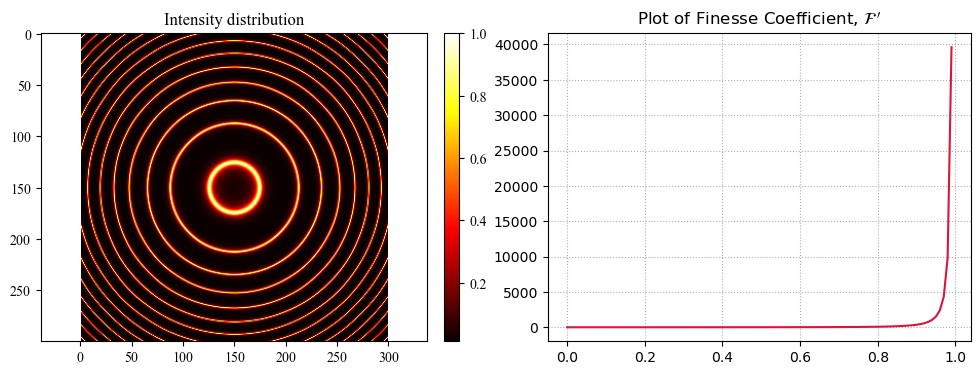

In [ ]:
# Preamble
import matplotlib.pyplot as plt
import numpy as np
from LightPipes import *

# Parameters
labda = 550*nm;     # Wavelength
size = 5*mm;        # Size of grid
N = 300             # Grid dimension
f = 100*mm;         # Lens focal length
r = 0.80;            # Reflectivity of mirror
d = 6*mm;           # Separation bewteen two mirrors
k = 2*np.pi/labda;  # Wavenumber
n = 1.0             # Medium refractive index

# Create matplotlib figure and axes 
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# Font Customization
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['figure.dpi'] = 100

# Laser start
F_prime = (4.0 * r)/ (1.0 - r)**2         # F'
finesse = (np.pi * np.sqrt(r)) / (1 - r)  # Finesse
F = Begin(size, labda, N);                # Create ray
I = Intensity(F, flag=1)                  # Normalised intensity (all generated points have equal intensity)
I0 = I[0][0]                              # Obtain initial intensity
step = size / N                           # Iteration step size = 0.0167mm

# This section calculates intensity, I at every point on the grid
# Does this by iterating all possible points (x0 = -size/2 to xn = size/2) where (x0 = -R to x = R)
# Loops over x-axes's grid dimension (N=300)
for i in range(1, N):
    x_ray = i * step
    # Loops over x-axes's grid dimension (N=300)
    for j in range(1, N):
        y_ray = j * step
        X = x_ray - (size/2)         # {x: -size/2 < x < size/2, or -R < x < R}
        Y = y_ray - (size/2)         # {y: -size/2 < y < size/2, or -R < y < R}
        radius = np.sqrt(X**2 + Y**2)   # Pythagoras
        theta = radius / f              # Small angle approximation for divergence, theta = tan(theta)
        Phi = 2 * k * n * d * np.cos(theta) # Phi angle (round trip)
        Inten = 1 / (1 + F_prime * np.sin(Phi/2)**2) # Assuming no loss and T + R = 1
        I[i][j] = I0 * Inten

# 1. Plot circular fringes
ax1.clear()
ax1.axis('on'); ax1.axis('equal');
ax1.set_title('Intensity distribution')
im = ax1.imshow(I, cmap='hot')
fig.colorbar(im, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04)

# 2. Plot finesse graph
r_lin = (np.arange(0, 100, 1)) / 100
Fin_lin = (np.pi * np.sqrt(r_lin)) / (1 - r_lin)
ax2.plot(r_lin, (4*r_lin) / (1 - r_lin)**2, color='crimson')
ax2.grid(True, ls=':')
ax2.set_title(r"Plot of Finesse Coefficient, $\mathcal{F}\,'$")

plt.show()

### B) When $R_1\neq R_2$

#### 1. Simple Simulation

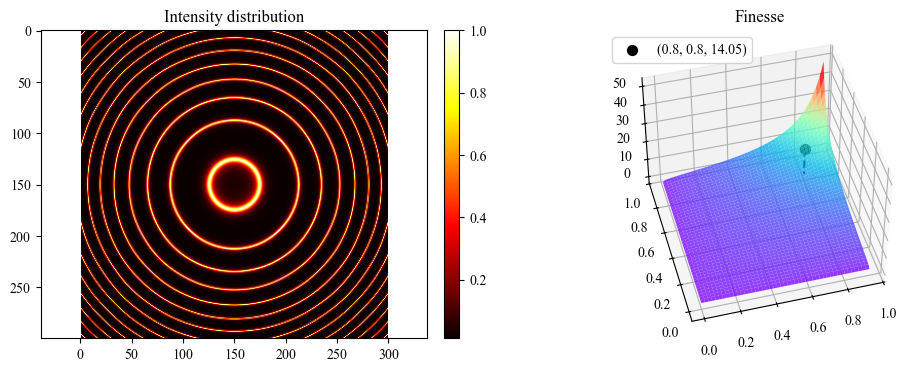

In [ ]:
# Preamble
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from LightPipes import *

# Parameters
labda = 550*nm;     # Wavelength
size = 5*mm;        # Size of grid
N = 300             # Grid dimension
f = 100*mm;         # Focal point of lens
r1 = 0.8;           # Reflectivity 1 of mirror
r2 = 0.8;           # Reflectivity 2 of mirror
d = 6*mm;           # Separation between two mirrors
k = 2*np.pi/labda;  # Wavenumber
n = 1.0             # Medium refractive index

# Create matplotlib figure and axes 
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

# Font Customization
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['figure.dpi'] = 100

# Laser start
F_prime = (4.0 * np.sqrt(r1 * r2))/ (1.0 - np.sqrt(r1 * r2))**2 # F'
F = Begin(size, (labda), N);        # Create ray
I = Intensity(F, flag=1)          # Normalised intensity (all generated points have equal intensity)
I0 = I[0][0]                      # Obtain initial intensity              

# This section draws the circular shape (rings)
# Does this by iterating all possible points (x0 = -size/2 to xn = size/2) where (x0 = -R to x = R)
# Loops over x-axes's grid dimension (N=300)
# Iteration step size = 0.0167mm
for i in range(1, N):
    x_ray = i * step
    # Loops over x-axes's grid dimension (N=300)
    for j in range(1, N):
        y_ray = j * step
        X = x_ray - (size/2)         # {x: -size/2 < x < size/2, or -R < x < R}
        Y = y_ray - (size/2)         # {y: -size/2 < y < size/2, or -R < y < R}
        radius = np.sqrt(X**2 + Y**2)   # Pythagoras
        theta = radius / f              # Small angle approximation, theta = tan(theta)
        Phi = k * n * d * np.cos(theta) # Phi angle (phase change should have no effect because reflected twice = 360°)
        Inten = 1 / (1 + F_prime * np.sin(Phi)**2) # Assuming no loss, T + R = 1
        I[i][j] = I0 * Inten

ax1.clear()
ax1.axis('on'); ax1.axis('equal');
ax1.set_title('Intensity distribution')
im = ax1.imshow(I, cmap='hot')
fig.colorbar(im, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04)

# Finesse
r1_lin = (np.arange(0, 95, 1)) / 100 # X
r2_lin = (np.arange(0, 95, 1)) / 100 # Y
z0 = (np.pi * np.power(r1*r2, 1/4)) / (1 - np.sqrt(r1*r2))
X, Y = np.meshgrid(r1_lin, r2_lin)
Z = (np.pi * np.power(X*Y, 1/4)) / (1 - np.sqrt(X*Y)) # Z

# Plot surface
ax2.plot_surface(X, Y, Z, cmap='rainbow', alpha=0.8)
ax2.scatter(r1, r2, z0, color='black', s=50, label=f"({r1}, {r2}, {z0:.2f})")
ax2.plot([r1, r1], [r2, r2], [z0,0], color='black', ls='--')
ax2.legend()
ax2.grid()
ax2.set_title('Finesse')

# Rotate camera
ax2.view_init(elev=45, azim=255)  # elev = up/down, azim = left/right

plt.show()

#### 2. Dynamic Simulation

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np
from LightPipes import *

from tkinter import *
from tkinter import ttk

###########################
# Tkinter Functions
###########################

def update_plot():
    r1 = R1_val.get();           # Reflectivity of mirror 1
    r2 = R2_val.get();           # Reflectivity of mirror 2
    d = d_val.get()*mm;          # Separation between two mirrors
    n = n_val.get()              # Medium refractive index 
    labda = labda_val.get()*nm   # Wavelength

    k = 2*np.pi/labda

    try:
        F_prime = (4.0 * np.sqrt(r1 * r2))/ (1.0 - np.sqrt(r1 * r2))**2
        finesse = (np.pi * np.power(r1*r2, 1/4)) / (1 - np.sqrt(r1*r2))
    except ZeroDivisionError:
        F_prime = 99999
        finesse = 0

    # This section draws the circular shape (rings)
    # Does this by iterating all possible points (x0 = -size/2 to xn = size/2) where (x0 = -R to x = R)
    # Loops over x-axes's grid dimension (N=300)
    x = np.linspace(-size/2, size/2, NN)
    y = np.linspace(-size/2, size/2, NN)
    XX, YY = np.meshgrid(x, y)
    radius = np.sqrt(XX**2 + YY**2)
    theta = radius / f
    Phi = 2 * k * n * d * np.cos(theta)
    Inten = 1 / (1 + F_prime * np.sin(Phi/2)**2)
    I = I0 * Inten

    # 1. Plot circular fringes
    global cbar, im

    try:
        cbar.remove()
        im.remove()
    except:
        pass

    im = ax1.imshow(I, cmap='hot')
    cbar = fig.colorbar(im, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04)
    
    # 2. Plot finesse graph
    global scatter2, plot2

    try:
        scatter2.remove()
        plot2[0].remove()
    except:
        pass

    scatter2 = ax2.scatter(r1, r2, finesse, color='black', s=50, label=rf"$\mathcal{{R_1}}={r1:.2f},\ \mathcal{{R_2}}={r2:.2f},\ \mathcal{{F}}={finesse:.2f}$")
    plot2 = ax2.plot([r1, r1], [r2, r2], [finesse,0], color='black', ls='--')
    ax2.grid(True)
    ax2.legend(loc='upper left')

    canvas.draw()


def update_R1(val):
    label_R1.config(text=f"Reflectivity, R1 = {float(val):.2f}")  # Format to 2 decimal places
    update_plot()

def update_R2(val):
    label_R2.config(text=f"Reflectivity, R2 = {float(val):.2f}")  # Format to 2 decimal places
    update_plot()

def update_n(val):
    label_n.config(text=f"Refractive index, n = {float(val):.2f}")  # Format to 2 decimal places
    update_plot()

def toggle_n_scale():
    if n_bool.get():
        n_scale.config(state="normal")
    else:
        n_scale.config(state="disabled")

def update_d(val):
    label_d.config(text=f"Distance between mirrors, d = {float(val):.2f}mm")  # Format to 2 decimal places
    update_plot()

def toggle_d_scale():
    if d_bool.get():
        d_scale.config(state="normal")
    else:
        d_scale.config(state="disabled")

def update_labda(val):
    label_labda.config(text=f"Wavelength, λ = {float(val):.0f}nm")  # Format to 2 decimal places
    update_plot()

def toggle_labda_scale():
    if labda_bool.get():
        labda_scale.config(state="normal")
    else:
        labda_scale.config(state="disabled")

def on_closing():
    # Ask user if they really want to quit
    if messagebox.askokcancel("Quit", "Do you want to quit?"):
        root.destroy()  # Close the window and exit app


###########################
# Matplotlib Customization
###########################

# Font Customization
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['figure.dpi'] = 100

# Create matplotlib figure and axes 
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax1.axis('on'); ax1.axis('equal');
ax1.set_title('Intensity Distribution')

ax2.set_title(r'Plot of Finesse, $\mathcal{F}$')
ax2.view_init(elev=45, azim=255)  # Rotate camera: elev = up/down, azim = left/right


###########################
# Simulation Start
###########################

# Parameters
labda = 550*nm;     # Wavelength
size = 5*mm;        # Size of grid
NN = 300            # Grid dimension
f = 100*mm;         # Focal point of lens
r1 = 0.8;           # Reflectivity 1 of mirror
r2 = 0.8;           # Reflectivity 2 of mirror
d = 6*mm;           # Separation between two mirrors
k = 2*np.pi/labda;  # Wavenumber
n = 1.0             # Medium refractive index

# Laser start
F = Begin(size, labda, NN)
I = Intensity(F, flag=1)          # Normalised intensity (all generated points have equal intensity)
I0 = I[0][0]                      # Obtain initial intensity

# Finesse surf
r1_lin = (np.arange(0, 95, 1)) / 100 # X
r2_lin = (np.arange(0, 95, 1)) / 100 # Y
XX, YY = np.meshgrid(r1_lin, r2_lin)
ZZ = (np.pi * np.power(XX*YY, 1/4)) / (1 - np.sqrt(XX*YY)) # Z

# Prevent unceccessary computation
ax2.plot_surface(XX, YY, ZZ, cmap='rainbow', alpha=0.8)


###########################
# TkAgg Start
###########################

root = Tk()
root.title("Fabry Perot Simulation")

# Frames
content = ttk.Frame(root, padding=(3,3,12,12))
frame1 = ttk.Frame(content, borderwidth=5, relief="ridge", width=200, height=100)
frame2 = ttk.Frame(content, borderwidth=5, relief="ridge")

# Matplotlib canvas
canvas = FigureCanvasTkAgg(fig, master=frame1)
canvas.draw()
canvas.get_tk_widget().pack(side=TOP, fill=X)

# Variables
R1_val = DoubleVar(value=0.5)
R2_val = DoubleVar(value=0.5)

n_bool = BooleanVar(value=False)
d_bool = BooleanVar(value=False)
labda_bool = BooleanVar()

n_val = DoubleVar(value=1.0)
d_val = DoubleVar(value=6.0)
labda_val = DoubleVar(value=550)

# Widgets
label_R1 = ttk.Label(frame2, text=f'Reflectivity, R1 = {R1_val.get():.2f}')
R1 = ttk.Scale(frame2, orient=HORIZONTAL, length=200, from_=0.00, to=1.00, variable=R1_val, command=update_R1)
R1.set(R1_val.get())

label_R2 = ttk.Label(frame2, text=f'Reflectivity, R2 = {R2_val.get():.2f}')
R2 = ttk.Scale(frame2, orient=HORIZONTAL, length=200, from_=0.00, to=1.00, variable=R2_val, command=update_R2)
R2.set(R2_val.get())

label_n = ttk.Label(frame2, text=f'Refractive index, n = {n_val.get():.2f}')
n_scale = ttk.Scale(frame2, orient=HORIZONTAL, length=200, from_=1.00, to=3.00, variable=n_val, command=update_n)
n_scale.set(n_val.get())
n_check = ttk.Checkbutton(frame2, text="Allow", variable=n_bool, onvalue=True, command=toggle_n_scale)

label_d = ttk.Label(frame2, text=f'Distance between mirros, d = {d_val.get():.2f}mm')
d_scale = ttk.Scale(frame2, orient=HORIZONTAL, length=200, from_=0.00, to=10.00, variable=d_val, command=update_d)
d_scale.set(d_val.get())
d_check = ttk.Checkbutton(frame2, text="Allow", variable=d_bool, onvalue=True, command=toggle_d_scale)

label_labda = ttk.Label(frame2, text=f'Wavelength, λ = {labda_val.get():.0f}nm')
labda_scale = ttk.Scale(frame2, orient=HORIZONTAL, length=200, from_=10, to=990, variable=labda_val, command=update_labda)
labda_scale.set(labda_val.get())
labda_check = ttk.Checkbutton(frame2, text="Allow", variable=labda_bool, onvalue=True, command=toggle_labda_scale)


# Grid
content.grid(column=0, row=0, sticky='nsew')
frame1.grid(column=0, row=0, columnspan=3, rowspan=2, sticky='nsew')
frame2.grid(column=0, row=2, columnspan=8, rowspan=2, sticky='nsew')

# Place widgets in center column (column=1)
col = 1  # center content

label_R1.grid(column=1, row=0, padx=5, pady=5, sticky='w')
R1.grid(column=1, row=1, padx=5, pady=5, sticky='w')

label_R2.grid(column=2, row=0, padx=5, pady=5, sticky='w')
R2.grid(column=2, row=1, padx=5, pady=5, sticky='w')

label_n.grid(column=col, row=4, padx=5, pady=2, sticky='w')
n_scale.grid(column=col, row=5, padx=5, pady=2, sticky='we')
n_check.grid(column=col+1, row=5, padx=5, pady=2, sticky='w')
toggle_n_scale()

label_d.grid(column=col, row=6, padx=5, pady=2, sticky='w')
d_scale.grid(column=col, row=7, padx=5, pady=2, sticky='we')
d_check.grid(column=col+1, row=7, padx=5, pady=2, sticky='w')
toggle_d_scale()

label_labda.grid(column=col, row=8, padx=5, pady=2, sticky='w')
labda_scale.grid(column=col, row=9, padx=5, pady=2, sticky='we')
labda_check.grid(column=col+1, row=9, padx=5, pady=2, sticky='w')
toggle_labda_scale()

label_n.grid(column=col, row=4, padx=5, pady=2, sticky='w')
n_scale.grid(column=col, row=5, padx=5, pady=2, sticky='we')
n_check.grid(column=col+1, row=5, padx=5, pady=2, sticky='w')
toggle_n_scale()

label_d.grid(column=col, row=6, padx=5, pady=2, sticky='w')
d_scale.grid(column=col, row=7, padx=5, pady=2, sticky='we')
d_check.grid(column=col+1, row=7, padx=5, pady=2, sticky='w')
toggle_d_scale()

label_labda.grid(column=col, row=8, padx=5, pady=2, sticky='w')
labda_scale.grid(column=col, row=9, padx=5, pady=2, sticky='we')
labda_check.grid(column=col+1, row=9, padx=5, pady=2, sticky='w')
toggle_labda_scale()

# Configure frame2 with 3 columns: left space, center content, right space
frame2.columnconfigure(0, weight=1)
frame2.columnconfigure(1, weight=0)
frame2.columnconfigure(2, weight=1)

update_plot()

# Set the protocol handler for window close event
root.protocol("WM_DELETE_WINDOW", on_closing)
                    
root.mainloop()

plt.close()